In [1]:
%load_ext autoreload
%autoreload 2
import sys 
import numpy as np
import pandas as pd

# RNN (Recurrent Neural Networks)
Articulos recomendado: 
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- http://blog.echen.me/2017/05/30/exploring-lstms/

## Que tienen de nuevo respecto a MLP y CNN?
- MLP y CNN solo aceptan un vector de entrada de tamaño fijo y devuelve un vector de salida de tamaño fijo
- RNN trabjan con secuencias tanto a la entrada como a la salida
- No tienen por que estrictamente tener una secuencia ni a la entrada ni a la salidad. De hecho hasta podrían no tener nada a la "entrada"

![rnn_types.jpeg](rnn_types.jpeg)

Aclaraciones: 
- Cada cuadrado NO es una neurona si no una capa que puede contener N neuronas
- Cada flecha representa la interconexión entre dos capas. Los pesos forman una matriz de la N1xN2 donde N1 y N2 son la cantidad de neuronas en cada capa respectivamente.

## Tipos
- **One to One**: CNN, MLP
- **One to many**: [Image captioning](https://www.youtube.com/watch?v=xKt21ucdBY0)
- **Many to one**: Sentiment Analisys, Detectar voz de hombre vs voz de mujer
- **Many to Many** [(sequence to sequence)](https://youtu.be/dkHdEAJnV_w): [Traducción](https://github.com/jganzabal/aind2-nlp-capstone/blob/master/machine_translation.ipynb) Dimensión de entrada differente a la de salida.
- **Many to Many Sincronizado**: Etiquetado de tramas de video, POS (Part of Speech) cada palabra se clasifica en verbo, articulo, etc, speech2text, text2speech, NER (Named Entity Recognition). Dimensión de entrada igual a dimensión de salida

# Modelos de lenguaje Generativos:
- Predecir la proxima palabra en funcion de las anteriores
- Predecir el proximo caracter en función de los anteriores

**Resultado**: Probabilidad dada la secuencia de caracteres o de palabras

**Aplicaciones de los modelos de lenguaje** (Mas allá de la posibilidad de generar texto):
- OCR
- Speach2Text
- Detección de autores

## "If training vanilla neural nets is optimization over functions, training recurrent nets is optimization over programs."
- Es una secuencia de ejecución mas que una clasificación
- Las RNN son Turing completo en principio [Turing Complete](https://en.wikipedia.org/wiki/Turing_completeness), [RNN Turing complete](http://binds.cs.umass.edu/papers/1995_Siegelmann_Science.pdf)

# Detalles de la arquitectura:

## Unidad de Elman o RNN unit

**Nota importante**: Cada unidad no es una neurona sino que una capa

![RNN_vs_FNN.png](RNN_vs_FNN.png)

¿Cual es el tamaño de $W_h$?

Todo se conecta con todo -> Si hay M hidden units tenemos $M^2$ $W_h$s 

## En ecuaciones:

### FFN

$h_t = f(W_x^T X_t + b_h)$

$y_t = softmax(W_o^T h_t + b_o)$

$f$ usualmente RELU, sigmoidea, etc

### RNN

$h_t = f(W_h^T h_{t-1} + W_x^T X_t + b_h)$

$y_t = softmax(W_o^T h_t + b_o)$

$f$ es tanh usualmente pero puede ser RELU, sigmoid, etc

### Ejemplo con dos neuronas en la capa oculta

La idea es comprender paso a paso los calculos en cada paso de la red hasta hallar el valor de la salida.

![unfold_RNN.png](unfold_RNN.png)

Primero calculamos la salida(ht) de la funcion de activacion 'f' que en este caso va a ser una 'tanh':

In [3]:
print_matrix = lambda name, matrix: print(f'{name}:\n{matrix.view()}')

# M: Cantidad de neuronas en la capa oculta.
M = 2
print('M:', M)

# h0: Valores iniciales de la capa oculta, vector columna de Mx1.
h0 = np.array([1, -2]).reshape(2, 1)
print_matrix('h(t=0)', h0)

# Wh: Matriz de pesos de capa oculta MxM.
Wh = np.array([[0, -1], [2, 1]])
print_matrix('Wh', Wh)

# Dimension de entrada 3 en este ejemplo.
Xt = np.array([1, -1, 2]).reshape(3,1) # Vector columna
print_matrix('X(t=1)', Xt)

# Dimension de Wx?
# Re: Dimensión 3x2 para que Wx.T sea de 2x3
Wx = np.array([[-1, 1], [1, 0], [2, 1]])
print_matrix('Wx', Wx)


# Dimensión Mx1
bh = np.array([-1, 1]).reshape(2,1)
print_matrix('bh', bh)


total_params_r_layer = Wh.shape[0] * Wh.shape[1] + Wx.shape[0] * Wx.shape[1] + bh.shape[0]

print('\nCantidad de parametros de recurrente(que la red tiene que aprender/ajustar):', total_params_r_layer)

M: 2
h(t=0):
[[ 1]
 [-2]]
Wh:
[[ 0 -1]
 [ 2  1]]
X(t=1):
[[ 1]
 [-1]
 [ 2]]
Wx:
[[-1  1]
 [ 1  0]
 [ 2  1]]
bh:
[[-1]
 [ 1]]

Cantidad de parametros de recurrente(que la red tiene que aprender/ajustar): 12


In [4]:
Wh.T # T: Roto en direccion agujas y luego mirror.

array([[ 0,  2],
       [-1,  1]])

In [5]:
Wh.T.dot(h0) # Producto escalar

array([[-4],
       [-3]])

In [6]:
 Wx.T.dot(Xt)

array([[2],
       [3]])

In [8]:
h_arg = Wh.T.dot(h0) + Wx.T.dot(Xt) + bh
h1 = np.tanh(h_arg) # Ver grafico tanh!

print(f'Argumneto de h(t):\n{h_arg}')
print(f'h(t=1):\n{h1}')

Argumneto de h(t):
[[-3]
 [ 1]]
h(t=1):
[[-0.99505475]
 [ 0.76159416]]


![1200px-Hyperbolic_Tangent.svg.png](1200px-Hyperbolic_Tangent.svg.png)

Calcula de la salida de la softmax:

In [9]:
# Salida de 3 neuronas en la capa oculta:

Wo = np.array([[0.5, 0.4],[0.3, 0.5],[0.1, 0.5]]).reshape(2,3)
bo = np.array([0.5, 0.1, 0.2]).reshape(3,1)
ao = Wo.T.dot(h0) + bo

print_matrix('Wo', Wo)
print_matrix('ao', ao)

softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

print('Salida:\n', softmax(ao))

total_params_out_layer = Wo.shape[0] * Wo.shape[1] + bo.shape[0]

print('\nCantidad de parametros de capa densa de salida:', total_params_out_layer)

Wo:
[[0.5 0.4 0.3]
 [0.5 0.1 0.5]]
ao:
[[ 0. ]
 [ 0.3]
 [-0.5]]
Salida:
 [[0.33825043]
 [0.45659032]
 [0.20515925]]

Cantidad de parametros de capa densa de salida: 9


## Con keras

In [10]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [11]:
rnn_neurons = 2 # M
time_steps = 1000 # T
n_features = 3 # D
input_shape = (time_steps, n_features)

In [12]:
input_shape

(1000, 3)

In [13]:
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.add(Dense(3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 2)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


## Desplegando (Unfolding) la RNN
#### BPTT (Back-Propagation Through Time)
- Secuencia de longitud 5

![unfold_RNN.png](unfold_RNN.png)

Observaciones:
- Es como una FNN con 5 hidden layers pero con pesos compartidos (Shared weights): $W_h, W_o, W_x$
- Donde habiamos visto pesos compartidos?
- Se puede pensar como si h fuera la entrada y X es una señal de control en cada paso

Preguntas:
- Son todas las Y importantes? En que casos?
- Que diferencia hay entre estado interno (internal state) de la RNN y los pesos?
- Cada cuanto se resetea el estado interno? Y los pesos?

# Detalles de la entrada $X$

## Entrada en Vanilla Networks:

NxD, donde N es la cantidad de muestras y D es la cantidad de features

In [14]:
import numpy as np

In [15]:
# Ejemplo N = 3, D = 2
Ex_1 = np.array([
    [0.5, 0.3], 
    [0.2, 0.1], 
    [0.7, 0.3]
])
print(Ex_1)
print(Ex_1.shape)

[[0.5 0.3]
 [0.2 0.1]
 [0.7 0.3]]
(3, 2)


## Entrada en RNNs:

Secuencias de longitud fija

NxTxD, donde T es la longitud de la secuencia

In [16]:
# Ejemplo N = 4, T = 3, D=2
Ex_2 = np.array([
    [
        [0.5, 0.3], 
        [0.2, 0.1], 
        [0.7, 0.3]
    ], 
    [
        [0.54, 0.1], 
        [0.23, 0.3], 
        [0.9, 0.1]
    ], 
    [
        [0.5, 0.3], 
        [0.2, 0.1], 
        [0.7, 0.3]
    ], 
    [
        [0.54, 0.1], 
        [0.23, 0.3], 
        [0.9, 0.1]
    ]
])
print(Ex_2)
print(Ex_2.shape)

[[[0.5  0.3 ]
  [0.2  0.1 ]
  [0.7  0.3 ]]

 [[0.54 0.1 ]
  [0.23 0.3 ]
  [0.9  0.1 ]]

 [[0.5  0.3 ]
  [0.2  0.1 ]
  [0.7  0.3 ]]

 [[0.54 0.1 ]
  [0.23 0.3 ]
  [0.9  0.1 ]]]
(4, 3, 2)


Secuencias de longitud variable (1 <= T <= 3):

In [17]:
Ex_3 = np.array([
    [
        [0.5, 0.3], 
        [0.7, 0.3]
    ], 
    [
        [0.54, 0.1], 
        [0.23, 0.3], 
        [0.9, 0.1]
    ], 
    [
        [0.7, 0.3]
    ], 
    [
        [0.54, 0.1], 
        [0.23, 0.3], 
        [0.9, 0.1]
    ]
])
print(Ex_3)
print(f'Samples: {Ex_3.shape}')
print(np.array(Ex_3[0]).shape)
print(np.array(Ex_3[1]).shape)
print(np.array(Ex_3[2]).shape)

[list([[0.5, 0.3], [0.7, 0.3]])
 list([[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]]) list([[0.7, 0.3]])
 list([[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]])]
Samples: (4,)
(2, 2)
(3, 2)
(1, 2)


En tensorflow es posible, en keras se suele hacer padding

¿Que pasa cuando tenemos longitudes distintas? Analizar el unfolding

### Desventajas de padding
- Podría haber una secuencia de longitud mayor en el test set. Que hacemos con eso?
- Es probable que los casos de secuencia largas sean poco probables por lo que realizaremos multiplicaciones de matrices innecesarias

## Ejemplos de preparación de datos para una RNN

### Predicción del valor de la acción de Apple

Predecir el valor de las acciones de una compañia.
- Se utilizarán las 5 observaciones anteriores 
- Tenemos los datos de 138 días
- ¿Cuanto vale N, T, D?

In [18]:
from matplotlib import pyplot as plt

apple_stock = np.loadtxt('apple/normalized_apple_prices.csv')
plt.plot(apple_stock)
plt.show()
print(f'Cantidad de samples: {len(apple_stock)}')

<Figure size 640x480 with 1 Axes>

Cantidad de samples: 138


In [19]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X, y = [], []

    # Lenght of series
    N = series.shape[0]
    
    # Generate inputs and outputs
    for i in range(N - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
        if i <=3:
            print(f'X({i}:{i+window_size}): {series[i:i+window_size]}, y({i+window_size}): {series[i+window_size]}')
        

    # reshape each 
    X = np.asarray(X)
    X.shape = (X.shape[0:2])
    
    y = np.asarray(y)
    y.shape = (len(y),1)
    return X,y

X_, y = window_transform_series(apple_stock, 5)

X(0:5): [-0.70062339 -0.82088484 -0.93938305 -0.9471652  -0.68785527], y(5): -0.8432590195361995
X(1:6): [-0.82088484 -0.93938305 -0.9471652  -0.68785527 -0.84325902], y(6): -0.8053201783108936
X(2:7): [-0.93938305 -0.9471652  -0.68785527 -0.84325902 -0.80532018], y(7): -0.820580730773294
X(3:8): [-0.9471652  -0.68785527 -0.84325902 -0.80532018 -0.82058073], y(8): -0.9202312393102279


In [20]:
print(X_.shape)
print(X_[0:3,:])
print(y.shape)
print(y[0:4,:])

(133, 5)
[[-0.70062339 -0.82088484 -0.93938305 -0.9471652  -0.68785527]
 [-0.82088484 -0.93938305 -0.9471652  -0.68785527 -0.84325902]
 [-0.93938305 -0.9471652  -0.68785527 -0.84325902 -0.80532018]]
(133, 1)
[[-0.84325902]
 [-0.80532018]
 [-0.82058073]
 [-0.92023124]]


Por que no se toman lo 5 ultimos valores? Por que no hay un valor y correspondiente!

#### Parece un detalle pero las capas recurrentes en Keras exigen el siguente formato:

In [21]:
X = X_.reshape(X_.shape[0], X_.shape[1], 1)

print(f'\n\n\n===========>> (N, T, D): {X.shape} <<===========\n\n')




===========>> (N, T, D): (133, 5, 1) <<===========




In [22]:
print(X[0:2,:])

[[[-0.70062339]
  [-0.82088484]
  [-0.93938305]
  [-0.9471652 ]
  [-0.68785527]]

 [[-0.82088484]
  [-0.93938305]
  [-0.9471652 ]
  [-0.68785527]
  [-0.84325902]]]


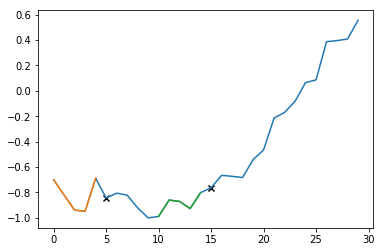

In [23]:
plt.plot(apple_stock[:30])
i1 = 0
plt.plot(range(i1,i1+5),X_[i1])
plt.scatter(i1+5, y[i1], marker='x', color='k')
i1 = 10
plt.plot(range(i1,i1+5),X_[i1])
plt.scatter(i1+5, y[i1], marker='x', color='k')

plt.show()

### Modelos de lenguaje
Predecir el siguiente caracter en función de los caracteres anteriores:
- Utilizar one-hot encoding para los caracteres
- Tamaño de ventana de 100
- Cantidad total de caracteres de la obra: 67561
- Cantidad de caracteres diferentes: 71

In [24]:
text = open('federico-garcia-lorca/bodas_de_sangre.txt').read()
number_of_chars = len(text)
all_chars = sorted(set(text))
print('-----------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------')
print('Cantidad de caracteres: ' + str(number_of_chars))
print('Cantidad de caracteres unicos: ' + str(len(all_chars)))
print(all_chars)
print('-----------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------')
print()
print(text[:997])

-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
Cantidad de caracteres: 67561
Cantidad de caracteres unicos: 71
['\n', ' ', '!', '(', ')', ',', '.', '1', '2', '3', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '¿', 'É', 'Ñ', 'á', 'é', 'í', 'ñ', 'ó', 'ú']
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------

BODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonardo
Mozos
Novia
Vecina
Novio
Leñadores
Suegra
Muchachas
Padre de la nov

In [25]:
def window_transform_text(text, window_size, step_size):
    # Containers for input/output pairs
    inputs, outputs = [], []
    
    # This is the number of iterations taking 
    # into acount the step_size and the window_size
    N = int((len(text) - window_size) / step_size)

    # Get inputs and outputs
    for i in range(0, N, step_size):
        inputs.append(text[i:i+window_size])
        outputs.append(text[i+window_size])
        
    return inputs, outputs

In [31]:
window_size = 100
step_size = 1

inputs, outputs = window_transform_text(text, window_size, step_size)

In [32]:
print(inputs[0])
print()
print('-----------------------------------------------------------------------------------------------------')
print('Salida:',outputs[0])
print('-----------------------------------------------------------------------------------------------------')
print()
print(inputs[1])
print('-----------------------------------------------------------------------------------------------------')
print('Salida:',outputs[1])
print('-----------------------------------------------------------------------------------------------------')

BODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonar

-----------------------------------------------------------------------------------------------------
Salida: d
-----------------------------------------------------------------------------------------------------

ODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonard
-----------------------------------------------------------------------------------------------------
Salida: o
-----------------------------------------------------------------------------------------------------


## ¿Como ingresamos a la red con caracteres?
### Categorical Data (One-hot encoding)

In [33]:
def encode_io_pairs(text,chars, window_size,step_size):
    num_chars = len(chars)
    chars_to_indices = dict((c, i) for i, c in enumerate(chars))
    # cut up text into character input/output pairs
    inputs, outputs = window_transform_text(text,window_size,step_size)
    
    # create empty vessels for one-hot encoded input/output
    X = np.zeros((len(inputs), window_size, num_chars), dtype=np.bool)
    y = np.zeros((len(inputs), num_chars), dtype=np.bool)
    
    # loop over inputs/outputs and tranform and store in X/y
    for i, sentence in enumerate(inputs):
        for t, char in enumerate(sentence):
            if char not in chars_to_indices:
                char = ' '
            X[i, t, chars_to_indices[char]] = 1
        out_char = outputs[i]
        if out_char not in chars_to_indices:
            out_char = ' '
        y[i, chars_to_indices[out_char]] = 1
    return X,y

In [34]:
X, y = encode_io_pairs(text, all_chars, window_size, step_size)

In [35]:
print('Caracteres codificado')
print(X[0,0:5].astype(int))

Caracteres codificado
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [36]:
print('(N,T,D):')
print(X.shape)

(N,T,D):
(67461, 100, 71)


## RNN en Keras
Definamos una capa RNN

In [37]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

In [38]:
from keras.layers import TimeDistributed

### SimpleRNN

In [39]:
rnn_neurons = 2
time_steps = 1000# T
n_features = 71 # D
input_shape = (time_steps, n_features)
input_shape

(1000, 71)

In [40]:
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 2)                 148       
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


Observaciones:
- Crece la cantidad de parametros con la cantidad de time_steps? 
Re: No.
- Como puedo utilizar un MLP para que tenga en cuenta los time_steps? Que desventajas tengo? 
Re: Cada entrada es un timestep. Desventaja supongo que la memoria es elnumero de entradas y no se concerva estado entre ejecuciones.
- rnn_neurons = 1, n_features = 1, por que es 3? Cuales son en el diagrama?

In [41]:
get_number_of_parameters = lambda rnn_neurons, n_features: rnn_neurons * n_features + rnn_neurons**2 + rnn_neurons

In [42]:
get_number_of_parameters(1,1)

3

### SimpleRNN + Dense para predecir caracteres
Armar modelo con los siguientes datos:
N,T,D = (67461, 100, 71)

In [43]:
# (67461, 100, 71)
rnn_neurons = 200 # Hyperparametro para jugar
time_steps = 100 # T
n_features =  71 # D

input_shape = (time_steps, n_features)
input_shape

(100, 71)

In [44]:
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape, return_sequences=True))
model.add(Dense(n_features, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 100, 200)          54400     
_________________________________________________________________
dense_2 (Dense)              (None, 100, 71)           14271     
Total params: 68,671
Trainable params: 68,671
Non-trainable params: 0
_________________________________________________________________


Observaciones:
- La cantidad de neuronas de la RNN queda para jugar (Overfitting, underfitting)

### SimpleRNN + Dense para stock prices

In [45]:
window_size = 40
rnn_cells = 10

model_rnn = Sequential()
model_rnn.add(SimpleRNN(rnn_cells, input_shape = (window_size,1)))
model_rnn.add(Dense(1))
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Observaciones:
- Capa densa. Que función de activación estamos usando? Lineal f(x)= x.

## Un error común

In [46]:
model_rnn_error = Sequential()
model_rnn_error.add(SimpleRNN(rnn_cells, input_shape = (1, window_size)))
model_rnn_error.add(Dense(1))
model_rnn_error.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


Preguntas:
- Que diferencia hay con la anterior? Solo hay un timestep.
- Por que la diferencia en cantidad de parámetros?
- Se puede pensar como un FNN (MLP)?

## FFN (MLP)

In [47]:
model_fnn = Sequential()
model_fnn.add(Dense(rnn_cells, input_shape=(window_size,) ))
model_fnn.add(Dense(1))
model_fnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [48]:
print('RNN')
print(model_rnn.layers[0].get_weights()[0].shape)
print(model_rnn.layers[0].get_weights()[1].shape)
print(model_rnn.layers[0].get_weights()[2].shape)
print()
print('RNN common error')
print(model_rnn_error.layers[0].get_weights()[0].shape)
print(model_rnn_error.layers[0].get_weights()[1].shape)
print(model_rnn_error.layers[0].get_weights()[2].shape)
print()
print('MLP')
print(model_fnn.layers[0].get_weights()[0].shape)
print(model_fnn.layers[0].get_weights()[1].shape)

RNN
(1, 10)
(10, 10)
(10,)

RNN common error
(40, 10)
(10, 10)
(10,)

MLP
(40, 10)
(10,)


# Como se podría entrener los ejemplos de STOCK Market y texto de manera mas eficiente con Many-to-Many?

## Stacking RNNs
### Podemos stackear varias capas?
![stack%20units.png](stack units.png)

In [50]:
# No funciona por que la salida no tiene la dimensión correcta
# (67461, 100, 71)
rnn_neurons = 100 # Hyperparametro para jugar
time_steps = 100 # T
n_features =  71# D

input_shape = (time_steps, n_features)
input_shape

(100, 71)

In [51]:
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.add(SimpleRNN(rnn_neurons))
model.add(Dense(n_features, input_shape = input_shape, activation="softmax"))
model.summary()

ValueError: Input 0 is incompatible with layer simple_rnn_9: expected ndim=3, found ndim=2

Por que falla?

In [52]:
# (67461, 100, 71)
rnn_neurons_1 = 200 # Hyperparametro para jugar
rnn_neurons_2 = 150 # Hyperparametro para jugar
time_steps = 100 # T
n_features =  71# D
input_shape = (time_steps, n_features)

print(input_shape)

(100, 71)


In [53]:
model = Sequential()
model.add(SimpleRNN(rnn_neurons_1, input_shape = input_shape, return_sequences=True))
model.add(SimpleRNN(rnn_neurons_2))
model.add(Dense(n_features, input_shape = input_shape, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 100, 200)          54400     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 150)               52650     
_________________________________________________________________
dense_7 (Dense)              (None, 71)                10721     
Total params: 117,771
Trainable params: 117,771
Non-trainable params: 0
_________________________________________________________________


# BPTT (Back-Propagation Through Time)
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/

![BPTT.png](BPTT.png)

Con esto podemos calcular la "cross-entropy" y derivar respecto a $W_o$,$W_h$ y W_x para hallar el gradiente.

![BPTT_graph.png](BPTT_graph.png)

Problema: Vanishing/Exploding Gradient
Soluciones:
- Gradient Cliping
- Truncated BPTT (Limitar la cantidad de unfoldings)
- LSTM

# Resumiendo:
## RNN vs Vanilla Network
- Menor cantidad de parametros para resolver lo mismo
- En principio una FFN podria resolver con la misma precisión un problema resuelto por una RNN, pero es demasiado complejo encontrar la solución
- La estructura de la RNN simplifica la tarea de encontrar una solución de manera eficiente
- Ya sabemos que el problema tiene naturaleza recurrente (necesitamos memoria)
- FNN tienen que tener tamaño fijo en contraste con las RNNs

## Las RNN pueden resolver problemas muy diferentes desde el punto de vista del tipo de procesamiento sobre la secuencia
- Secuencia temporal modelada con "longitud infinita": Valor de acciones - Modelos tipo AR(N)
- Secuencias finitas "independientes" unas de otras: Sentiment analisys (Longitud variable), paridad (Longitud fija)
- Modelos de lenguaje: Por caracter o por palabra
- Seq2Seq: Traducción, chatbots, Image captioning

# LSTM (Long Short Term Memory) y GRU (Gated Recurrent Unit)

Si queremos que un modelo de lenguaje genere texto de este tipo:

Albert Einstein was a German-born theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics (alongside quantum mechanics). **His** work is also known for its influence on the philosophy of science. **He** is best known by the general public for his mass–energy equivalence formula E = mc2 (which has been dubbed "the world's most famous equation"). **He** received the 1921 Nobel Prize in Physics "for **his** services to theoretical physics, and especially for his discovery of the law of the photoelectric effect", a pivotal step in the evolution of quantum theory.

Necesitamos memoria a largo plazo, que "recuerde" que se esta hablando de una persona de genero masculino y respete la gramática a lo largo del texto

![lstm.png](lstm.png)

- f -> forget Gate: "Porcentaje" que se queda de la LTM anterior
- i -> Remeber Gate: "Porcentaje" que pasa de lo actual
- o -> Learn Gate: "Porcentaje" a la salida o H (Recordar que h y la salida son lo mismo o STM)

## Ejemplo Cantidad de parametros

In [66]:
from keras.layers import LSTM
rnn_neurons = 1
time_steps = 100 # T
n_features = 1 # D
input_shape = (time_steps, n_features)

input_shape

(100, 1)

In [67]:
model = Sequential()
model.add(LSTM(rnn_neurons, input_shape = input_shape))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [68]:
get_number_of_LSTM_params = lambda rnn_neurons, n_features: (rnn_neurons*n_features + rnn_neurons**2 + rnn_neurons)*4

In [69]:
get_number_of_LSTM_params(rnn_neurons, n_features)

12

### En las GRU $i_t$ y $f_t$ son complementarias $i_t + f_t=1$ por lo tanto las GRUs poseen menos parametros. Ademas, no se hace diferencia entre $c_t$ y $h_t$

### En las LSTM $c_t$ y $h_t$ son diferentes por lo que el estado de la celula es diferente a la salida. Esto es diferente tanto en la simpleRNN como en la GRU

## Ejemplo usando Model Api de Keras
https://keras.io/models/model/

In [70]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, TimeDistributed

features = 100
cells = 256
return_sequences=True

input_data = Input(shape=(None, features), name="inputs")
LSTM_cell = LSTM(cells, return_state=True, return_sequences=return_sequences, name="Encoder_LSTM")
LSTM_outputs, LSTM_state_h, LSTM_state_c = LSTM_cell(input_data)

print('LSTM')
print(LSTM_outputs) # LSTM_outputs y LSTM_state_h son diferentes solo si return_sequences=True
print(LSTM_state_h)
print(LSTM_state_c)
print()

GRU_cell = GRU(cells, return_state=True, return_sequences=return_sequences, name="Encoder_GRU")
GRU_outputs, GRU_state_h = GRU_cell(input_data)
print('GRU')
print(GRU_outputs)
print(GRU_state_h)

LSTM
Tensor("Encoder_LSTM_1/transpose_1:0", shape=(?, ?, 256), dtype=float32)
Tensor("Encoder_LSTM_1/while/Exit_2:0", shape=(?, 256), dtype=float32)
Tensor("Encoder_LSTM_1/while/Exit_3:0", shape=(?, 256), dtype=float32)

GRU
Tensor("Encoder_GRU_3/transpose_1:0", shape=(?, ?, 256), dtype=float32)
Tensor("Encoder_GRU_3/while/Exit_2:0", shape=(?, 256), dtype=float32)


In [71]:
# Esto es solo un ejemplo de como definir el modelo Model Api en Keras
# La cantidad de neuronas de la GRU tiene que ser igual a la cantidad de features 
# con lo que sale de la LSTM. Tambien return_sequences tiene que ser True
print(LSTM_outputs)

stacked_output, _ = GRU_cell(LSTM_outputs)

model = Model(inputs=input_data, outputs=stacked_output)
model.summary()

Tensor("Encoder_LSTM_1/transpose_1:0", shape=(?, ?, 256), dtype=float32)


ValueError: Input 0 is incompatible with layer Encoder_GRU: expected shape=(None, None, 100), found shape=(None, None, 256)

# Bidirectional RNNs

In [72]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional
features = 256
cells = 256
return_sequences=True

input_data = Input(shape=(None, features))
LSTM_cell = LSTM(cells, return_state=True, return_sequences=return_sequences)
Bi_LSTM_cell = Bidirectional(LSTM_cell)
print(Bi_LSTM_cell)
LSTM_cell(input_data)
#LSTM_outputs, LSTM_state_h2, LSTM_state_h1, LSTM_state_c1, LSTM_state_c2 = Bi_LSTM_cell(input_data)
#print('LSTM')
#print(LSTM_outputs) # LSTM_outputs y LSTM_state_h son diferentes solo si return_sequences=True
#print(LSTM_state_h)
#print(LSTM_state_c)
#print()

[<tf.Tensor 'lstm_5/transpose_1:0' shape=(?, ?, 256) dtype=float32>,
 <tf.Tensor 'lstm_5/while/Exit_2:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 256) dtype=float32>]

# Aplicaciones
- Traducción
- **No es buena** para predecir el futuro en secuencias temporales
- Clasificación de imagenes

![BiLSTM-Image-classif.png](biLSTM-image-class-complete.png)

[](BiLSTM-Image-classif)